### Loading Python Modules

In [3]:
### for array operations
import numpy as np

### for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### for operations on FITS images
from astropy.io import fits

### statistics functions needed in this tutorial
from scipy import stats
from scipy.stats import norm

In [28]:
### "fits.open" opens the FITS file
hdulist = fits.open('/Users/ludus/astrolab/Lab1/CCD_data/Bias/ccd_bias.00000000.BIAS.FIT')


In [29]:
### let's look at what's in it
### in this case, a single extention, i.e. it has index 0
hdulist.info()

Filename: /Users/ludus/astrolab/Lab1/CCD_data/Bias/ccd_bias.00000000.BIAS.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   (1024, 1024)   int16 (rescales to uint16)   


In [49]:
### an image 
header = hdulist[0].header

In [31]:
### let's look at the header
header

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
BSCALE  = +1.000000000000E+000                                                  
BZERO   = +3.276800000000E+004                                                  
BIAS    =                  100                                                  
FOCALLEN= +0.000000000000E+000                                                  
APTAREA = +0.000000000000E+000                                                  
APTDIA  = +0.000000000000E+000                                                  
DATE-OBS= '2024-08-29T01:45:12.748'                                             
TIME-OBS= '01:45:12.748     

In [32]:
### let's look at the image data now
imagedata = hdulist[0].data

In [33]:
### for plotting the histogram, calculating statistics, etc., it's useful to convert the 2d array into a 1d list:
countvalues = imagedata.flatten()

In [34]:
countvalues.shape

(1048576,)

In [35]:
### first, let's look at the maximum and minimum counts
print(np.max(countvalues))
print(np.min(countvalues))

6693
974


### Section 4.1.1

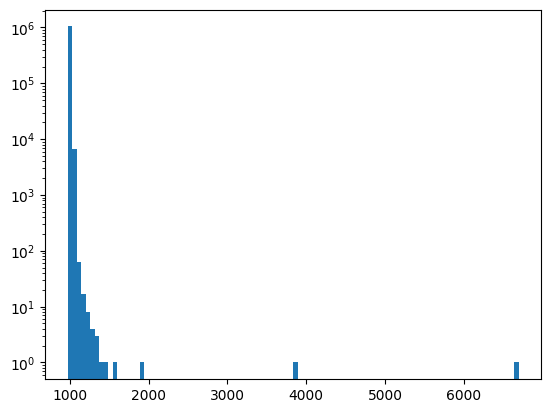

In [36]:
### plot a histogram, using a logarithmic y-axis
plt.hist(countvalues,bins=100);
plt.yscale('log')

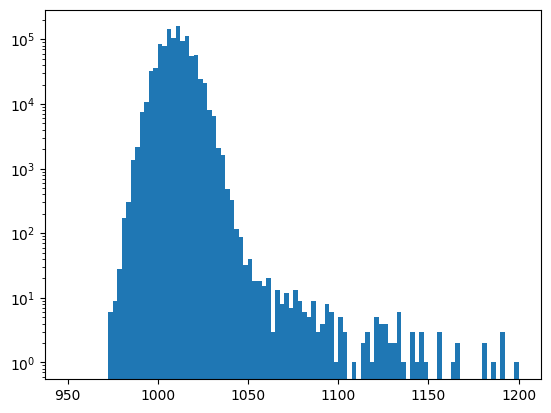

In [39]:
### let's re-plot, specifying a smaller range, and the number of bins:
plt.hist(countvalues,range=[950,1200], bins=100);
plt.yscale('log')

In [40]:
### compute the mean, the median, the mode, and the standard deviation:
print(np.mean(countvalues))
print(stats.mode(countvalues)[0])
print(np.median(countvalues))
print(np.std(countvalues))

1010.1095876693726
1009
1010.0
10.283390004317289


### Defining the cut to eliminate outliers.

In [54]:
### repeat the same, but clip "outliers":

clippedvalues = countvalues[countvalues<1060]

print(np.mean(clippedvalues))
print(stats.mode(clippedvalues)[0])
print(np.median(clippedvalues))
print(np.std(clippedvalues))

read_noise_counts = np.std(clippedvalues)

1010.0804135570716
1009
1010.0
7.955336927362054


### Number of excluded counts (Not necessarily number of hot pixels)

In [42]:
print(countvalues.shape[0] - clippedvalues.shape[0])

208


### Section 4.1.2

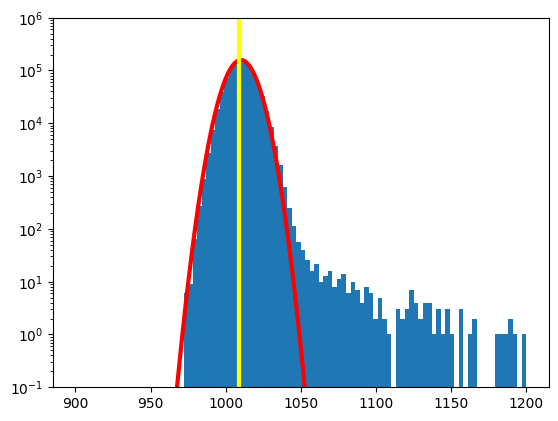

In [45]:
### overplot a normal distribution, as specified by the mean and standard deviation

cmin=900
cmax=1200
nbins=100
normalization=(cmax-cmin)/nbins*len(countvalues[(countvalues>=cmin) & (countvalues<=cmax)])

clipmin=cmin
clipmax=1060
clippedvalues = countvalues[(countvalues>=clipmin) & (countvalues<=clipmax)]

mu=np.mean(clippedvalues)
sig=np.std(clippedvalues)
mode=stats.mode(clippedvalues)[0]

xarray=np.linspace(cmin,cmax,nbins*10)
yarray=normalization*norm.pdf(xarray,loc=mu, scale=sig)

plt.hist(countvalues,range=[cmin,cmax], bins=nbins);
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarray,yarray,color="red",linewidth=3.0)
plt.axvline(x=mode,linewidth=3.0,color="yellow")

In [47]:
print(mu)
print(sig)
print(mode)

1010.0806992542738
7.956210481712265
1009


In [51]:
gain = header['EGAIN']
print(gain)

2.06


In [56]:
read_noise_electrons = read_noise_counts * gain
print(read_noise_electrons)

16.38799407036583


#### Is the read noise (measured in number of electrons) consistent with the manufacturer’s description?

Answer: Mostly. The manufacturer's description is 14.8, which is close enough.

### Section 4.2.1

#### Make a median combine of the series of 10 dark frames with the same exposure time. This is a master dark frame.

(10, 1024, 1024)
[[1058.  1053.  1062.5 ... 1026.5 1021.5 1027.5]
 [1069.  1051.5 1053.5 ... 1025.5 1148.5 1027.5]
 [1071.5 1058.  1052.  ... 1022.5 1030.  1054. ]
 ...
 [1055.  1054.  1046.  ... 1032.5 1041.  1035. ]
 [1049.  1043.  1050.  ... 1034.5 1040.5 1036.5]
 [1048.5 1049.5 1048.  ... 1042.5 1036.5 1041. ]]


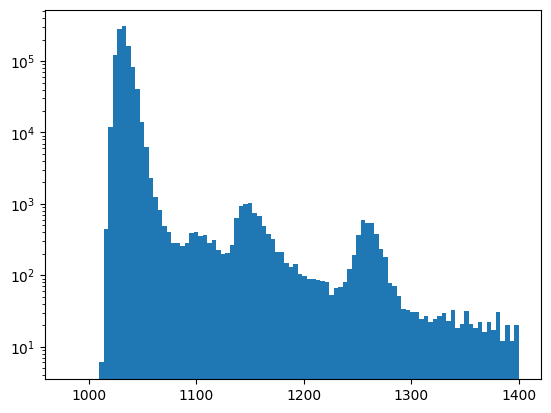

In [62]:
import glob

files = glob.glob('/Users/ludus/astrolab/Lab1/CCD_data/3.2.2/ccd_dark_30s_.*.DARK.FIT')

imagedata = []

for f in files:
    #print f
    ff = fits.open(f)
    #np.append(imagedata, [ff[0].data])
    imagedata.append(ff[0].data)

idat = np.array(imagedata)
print(np.shape(idat))
print(np.median(idat, axis=0))
dark_median = np.median(idat, axis=0)


### for plotting the histogram, calculating statistics, etc., it's useful to convert the 2d array into a 1d list:
countvalues = dark_median.flatten()

### let's re-plot, specifying a smaller range, and the number of bins:
plt.hist(countvalues, range=[980, 1400], bins=100);
plt.yscale('log')

#### Identify the “hot” pixels in the master dark frame.

2316


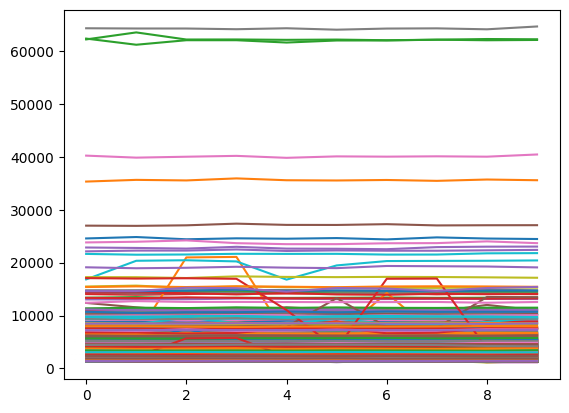

In [73]:
index_hotx, index_hoty = np.where(dark_median > 1300)
hot_only = idat[:, index_hotx, index_hoty]

print(len(hot_only[0]))
for i in range(len(hot_only[0])):
               
    plt.plot(np.arange(10), hot_only[:, i])

#### Are these pixels “hot” in all the individual images with this exposure time? Are there pixels that are hot (or warm) in some individual images, but not others? What could these be?

Nearly all of these hot pixels are hot in all indivual frames, but it appears that a small amount of these pixels are only hot for a few frames. This could be due to cosmic ray detection.

### Section 4.2.2

#### For each dark frame in the time series, measure the mean and standard deviation. Make sure to limit the range of count values so that the measurements are a good description of the bulk of the count values (similar to what you did for the bias frame).

In [4]:
import glob

files = glob.glob('/Users/ludus/astrolab/Lab1/CCD_data/3.2.2/ccd_dark_30s_.*.DARK.FIT')

for f in files:
    ff = fits.open(f)
    imagedata = ff[0].data
    countvalues = imagedata.flatten()
    clippedvalues = countvalues[countvalues<1060]

    print(np.mean(clippedvalues))
    print(np.std(clippedvalues))

    means = np.mean(clippedvalues)
    stdevs = np.std(clippedvalues)

    

1032.394535897338
9.333536896317497
1032.3729395261998
9.308932014630269
1032.269128374733
9.32316863037638
1032.2915691221335
9.355280092911203
1032.5558911205208
9.329262291672372
1032.0625729154249
9.349771080710303
1032.3237938294267
9.336343346924352
1032.4424247757327
9.324793546146685
1032.1025015658604
9.307348735549224
1032.1078984140634
9.328162953769999


#### For each frame, determine the statistical uncertainty on the mean counts by considering each pixel an independent measurement of the mean counts.

In [ ]:
## Statistical Uncertainty with large number of counts = sqrt(N)
for 

#### Systematic uncertainties are generally more difficult to estimate. Here, you can estimate it by changing the range of count values from which you compute the mean. Which uncertainty dominates?

#### Plot the mean counts against the exposure time for your dark frames taken at 0◦C. Make sure to include error bars that indicate the uncertainty. 

#### Perform a linear regression.

#### Make a second plot that shows the residuals of the data points (with uncertainties) relative to the linear regression.

#### Is the best-fit line a good description of the data?

#### What is the dark current in electrons per pixel per second? Compare it to the manufacturer’s specification.

 #### Estimate the dark current for the other temperature at which you took a bias and dark frame. Explain why or why not it changes.